In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, read_events
from obspy.imaging.beachball import beach
import pandas as pd
import geopandas as gpd
import fiona
import requests
import zipfile
import numpy as np
import subprocess
from netCDF4 import Dataset
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri.cm as SCM6
from matplotlib import cm
import cartopy.feature as cfeature
import matplotlib.font_manager
import matplotlib.colors as mcolors

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'

## Read in global plate boundary geometry shapefile

In [3]:
PB2002 = gpd.read_file('/Users/sph1r17/Downloads/PB2002_boundaries.shp')

## Read in global CMT catalogue

In [4]:
cat_gcmt = read_events("/Users/sph1r17/GLOBAL_CATALOGUES/GCMT/combo.ndk")

## Convert NZ NIWA topography/bathymetry grid to NETCDF file

In [ ]:
# trasform txt file into netCDF grid file
command = ['gdalwarp','-s_srs','EPSG:3994','-t_srs','EPSG:4326','--config',
           'CENTER_LONG','180','-overwrite',
           '/Users/sph1r17/Downloads/NZBathy_DTM_2016_ascii_grid/nzbathymetry_2016_ascii-grid.txt',
           'bathy.nc']
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print(stdout,stderr)

# grdcut
command = ['gmt','grdcut', 'bathy.nc',
           '-R175/180/-42/-35','-Gbathy_cut.nc']
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print(stdout,stderr)

In [6]:
lonmin, lonmax, latmin, latmax = 177, 179.7, -39.4, -38.2 
# Get stations and earthquakes
cli = Client("IRIS")
inv = cli.get_stations(net="3C", startafter=UTCDateTime(2015,1,1))
nz3d_lons, nz3d_lats = zip(*[[sta.longitude, sta.latitude] for sta in inv[0]])
inv = cli.get_stations(net="YH", startafter=UTCDateTime(2014,1,1), endbefore=UTCDateTime(2016,1,1),
                      maxlatitude=0)
hob_lons, hob_lats = zip(*[[sta.longitude, sta.latitude] for sta in inv[0]])
cli = Client("GEONET")
inv = cli.get_stations()
gns_lons, gns_lats = zip(*[[sta.longitude, sta.latitude] for sta in inv[0]])

cat = cli.get_events(minlatitude=latmin, maxlatitude=latmax,
                     minlongitude=lonmin, maxlongitude=lonmax, minmagnitude=3.0,
                     starttime=UTCDateTime(2010,1,1))
eq_lons, eq_lats, eq_z, eq_mags = zip(*[[evt.preferred_origin().longitude,
                                         evt.preferred_origin().latitude,
                                         evt.preferred_origin().depth/1000,
                                         evt.preferred_magnitude().mag] for evt in cat])

# Load in NZ3D stations
jam_df = pd.read_csv("jamstec_locs.dat", sep='\t')
print(jam_df)

In [9]:
def read_netcdf(fn):
    """ Read in netcdf file (e.g., topograph/bathymetry, slab geometry)"""
    fh = Dataset(fn, mode='r')
    try:
        x = fh.variables['lon'][:]; y = fh.variables['lat'][:]; z = fh.variables['z'][:]
    except:
        x = fh.variables['x'][:]; y = fh.variables['y'][:]; z = fh.variables['z'][:]
    fh.close()
    return (x, y, z)


def hillshade(z, vmin, vmax, az, alt, cmap=SCM6.grayC_r):
    """
    Applying hillshading based on given azimuth and inclination angle.
    Uses Scientific Colour Maps gray palette
    """
    ls = LightSource(azdeg=az, altdeg=alt)
    rgb = ls.shade(np.array(z), vmin=vmin, vmax=vmax, cmap=cmap)
    return rgb


def plot_inset_map(ax, main_extent, size="25%", inset_loc="upper right"):
    """Plot a global inset map showing location of main map"""
    x1, x2, y1, y2 = main_extent
    ax2 = inset_axes(ax, width=size, height=size, loc=inset_loc, axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(map_projection=ccrs.Orthographic(central_latitude=np.mean([y1,y2]),
                                                                   central_longitude=np.mean([x1, x2]))))
    ax2.set_global()
    ax2.stock_img()
    ax2.add_feature(cfeature.COASTLINE)
    ax2.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], transform=ccrs.Geodetic(), c="red")
    

def eq_depth_cm(min_depth=0, max_depth=200):
    """Make a normalised colourmap for colouring seismicity / slab contours"""
    norm = matplotlib.colors.Normalize(vmin=min_depth, vmax=max_depth)
    m = cm.ScalarMappable(norm=norm, cmap=SCM6.buda_r)  
    return(norm, m)


def get_earthquakes_2list(main_extent, mag_mult, mag_power, client="IRIS"):
    """Retrieve catalog and convert into list for plotting points"""
    c = Client(client)
    x1, x2, y1, y2 = main_extent
    cat = c.get_events(minlongitude=x1, maxlongitude=x2, minlatitude=y1, maxlatitude=y2,
                   minmagnitude=4, starttime=UTCDateTime(1970, 1, 1))
    eq_lons, eq_lats, eq_z, eq_mags = zip(*[[evt.preferred_origin().longitude,
                                         evt.preferred_origin().latitude,
                                         evt.preferred_origin().depth/1000,
                                         evt.preferred_magnitude().mag] for evt in cat])
    eq_mags = [mag_mult*m**mag_power for m in eq_mags]
    return(eq_lons, eq_lats, eq_z, eq_mags)

In [16]:
def plot_map(figsize, extent, max_elev, max_depth_cmap, mag_mult, mag_power, z_cmap,
             boundaries, trench_str, trench_label_loc, trench_label_rot, 
             eq_client, bath_fn, slab_fn, illum_az, illum_alt, inset_loc):
    """Main plotting function"""
    x1, x2, y1, y2 = extent
    fig = plt.figure(figsize=figsize)  
    e_lons, e_lats, eq_z, eq_mags = get_earthquakes_2list([x1, x2, y1, y2], mag_mult, mag_power,
                                                          client=eq_client)
    trench = PB2002[PB2002["Name"].isin(boundaries)]
    topo_x, topo_y, topo_z = read_netcdf(bath_fn)
    topo_z_illum = hillshade(topo_z, vmin=-max_elev, vmax=max_elev, az=illum_az, alt=illum_alt)
    slab_x, slab_y, slab_z = read_netcdf(slab_fn)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent)
    im = ax.imshow(topo_z_illum, origin='lower',alpha=1, interpolation='gaussian',
                   extent=[topo_x.min(), topo_x.max(), topo_y.min(), topo_y.max()])  # Hillshading
    ax.contourf(topo_x, topo_y, topo_z, levels=np.arange(-max_elev, max_elev+100, 100), cmap=SCM6.oleron,
                alpha=0.75, antialiased=True)  # Topography / bathymetry
    ax.text(trench_label_loc[0], trench_label_loc[1], "{} trench".format(trench_str),
            rotation=trench_label_rot, fontsize=11, ha="center", va="center",
            bbox=dict(fc="white", alpha=0.7, boxstyle='round'))
    trench.plot(ax=ax, ec="white")
    norm, m = eq_depth_cm(min_depth=0, max_depth=max_depth_cmap )  # Colorbar for earthquake/slab depth
    ax.contour(slab_x, slab_y, np.abs(slab_z), levels=np.arange(20, max_depth_cmap+20, 20), cmap=z_cmap, norm=norm,
               alpha=0.7, linestyles=["dashed"], label="Slab contour")  # Slab contours
    ax.scatter(e_lons, e_lats, s=eq_mags, c=np.array(eq_z), cmap=z_cmap, norm=norm, alpha=0.6, ec="k")  # Quakes
    
    # Plot GCMTs
    cat_gcmt_filt = cat_gcmt.filter(
        "longitude > {}".format(x1), "longitude < {}".format(x2),
        "latitude > {}".format(y1), "latitude < {}".format(y2))
    for evt in cat_gcmt_filt:
        orig = evt.preferred_origin()
        np1 = evt.preferred_focal_mechanism().nodal_planes.nodal_plane_1
        fm = beach([np1.strike, np1.dip, np1.rake], xy=(orig.longitude, orig.latitude),
                   width=.12, linewidth=0.45, alpha=0.8,
                   facecolor=m.to_rgba(orig.depth/1000))
        fm.set_zorder(10); ax.add_collection(fm)
    cbar = plt.colorbar(m, label="Earthquake / slab depth (km)")
    
    ax.ticklabel_format(useOffset=False)
    gl = ax.gridlines(draw_labels=True, linestyle="--"); gl.xlabels_bottom = False; gl.ylabels_right = False
    
    plot_inset_map(ax, main_extent=extent, inset_loc=inset_loc)
    return(fig, ax, topo_z_illum, topo_x, topo_y, topo_z)

## Eastern Caribbean subduction zone example

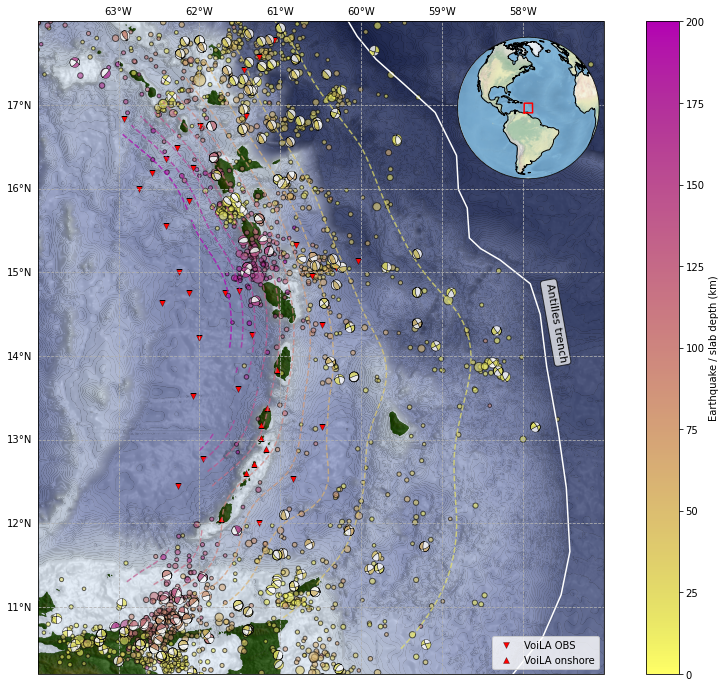

In [89]:
bath_fn = "/Users/sph1r17/Dropbox/SHicks_NERCIRF_2020_proposal_oxford/AntillesMap/GEBCO_2014_2D-66_-57_9.2_18.5.grd"
slab_fn = "/Users/sph1r17/Dropbox/SHicks_NERCIRF_2020_proposal_oxford/AntillesMap/Bieslab.grd"

fig, ax = plot_map(figsize=(15, 12), extent=(-64, -57, 10.2, 18), max_elev=7000, max_depth_cmap=200,
              mag_mult=0.05, mag_power=4, z_cmap=SCM6.buda_r, boundaries=["CA/SA"], trench_str="Antilles",
              trench_label_loc=(-57.6, 14.4), trench_label_rot=-80,
              eq_client="USGS", bath_fn=bath_fn, slab_fn=slab_fn,
              illum_az=110, illum_alt=75,inset_loc="upper right")

# Plot stations
inv = read_inventory("/Users/sph1r17/Dropbox/VOILA_catalogues/metadata/XX/XX.xml")
sta_lons, sta_lats = zip(*[[sta.longitude, sta.latitude] for sta in inv[0]])
inv = read_inventory("/Users/sph1r17/Dropbox/VOILA_catalogues/metadata/XZ/XZ.xml")
XZ_lons, XZ_lats = zip(*[[sta.longitude, sta.latitude] for sta in inv[0]])
ax.scatter(sta_lons, sta_lats, marker="v", label="VoiLA OBS", ec='k', c="red", lw=0.3)
ax.scatter(XZ_lons, XZ_lats, marker="^", label="VoiLA onshore", ec='k', c="red", lw=0.3)

ax.legend(loc="lower right")
plt.savefig("la_map.png", dpi=300, bbox_inches="tight", transparent=False)

## Northern Hikurangi subduction zone example

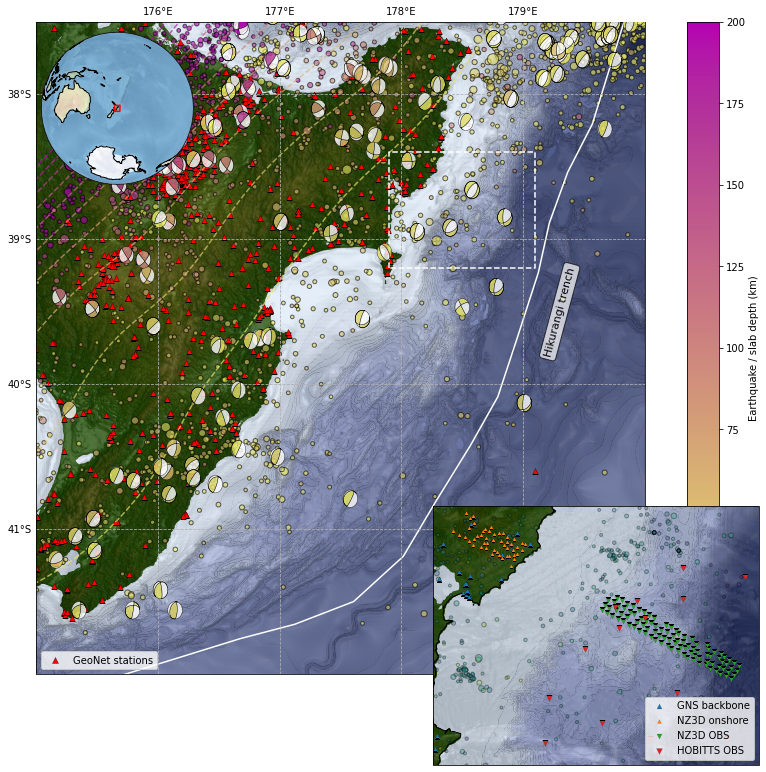

In [25]:
bath_fn = "bathy_cut.nc"
slab_fn = "ker_slab2_dep_02.24.18.grd"
extent = (175, 180, -42, -37.5)

fig, ax, topo_z_illum, topo_x, topo_y, topo_z = plot_map(
    figsize=(15, 12), extent=extent, max_elev=5000, max_depth_cmap=200,
    mag_mult=0.05, mag_power=4, z_cmap=SCM6.buda_r, boundaries=["KE/PA"], trench_str="Hikurangi",
    trench_label_loc=(179.3, -39.5), trench_label_rot=75, eq_client="USGS",
    bath_fn=bath_fn, slab_fn=slab_fn, illum_az=110, illum_alt=75,
    inset_loc="upper left")

ax.scatter(gns_lons, gns_lats, marker="^", label="GeoNet stations", ec='k', c="red", lw=0.3)
ax.legend(loc="lower left")

x1 = 177.9; x2 = 179.1; y1 = -39.2 ; y2 = -38.4 
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], ls="--", c="white")
ax1 = fig.add_axes([0.5, 0.02, 0.4, 0.3], projection=ccrs.PlateCarree())
ax1.set_extent([x1, x2, y1, y2])

im = ax1.imshow(topo_z_illum, extent=extent, origin='lower',alpha=1, zorder=-1, interpolation='gaussian')
ax1.contourf(topo_x, topo_y, topo_z, levels=np.arange(-4000, 4100, 100), cmap=SCM6.oleron, alpha=0.75,
             antialiased=True)
coast.plot(ax=ax1, ec="k", facecolor="None")
trench.plot(ax=ax1, ec="white")
ax1.set_extent([lonmin, lonmax, latmin, latmax])
c = ax1.scatter(eq_lons, eq_lats, s=[0.3*m**3 for m in eq_mags], c=np.array(eq_z), cmap="viridis", vmax=50,
               alpha=0.35, ec="k")
ax1.scatter(gns_lons, gns_lats, marker="^", s=25, label="GNS backbone", ec='k', lw=0.1)


ax1.scatter(nz3d_lons, nz3d_lats, marker="^", s=15, label="NZ3D onshore", ec='k', lw=0.1)
ax1.scatter(jam_df["Lng"], jam_df["Lat"]*-1, label="NZ3D OBS", s=25, ec='k', lw=0.1, marker="v")

ax1.scatter(hob_lons, hob_lats, s=35, label="HOBITTS OBS", ec='k', lw=0.1, marker="v")
ax1.set_xlim([x1, x2])
ax1.set_ylim([y1, y2])
ax1.legend(loc="lower right")